In [1]:
!pip install bnlp_toolkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.9 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=46c69c9b594b2310a2ad554bb9e4734659464c77e492e1af9ff27888cff9bb85
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.10.0
    Uninstalling emoji-2.10.0:
      Successfully uninstalled emoji-2.10.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from bnlp import NLTKTokenizer

In [3]:
df_train = pd.read_excel("/kaggle/input/emo-clean/emonoba_train_clean.xlsx")

In [4]:
df_train.head()

,Data,Love,Joy,Surprise,Anger,Sadness,Fear
0,লকাল বাস ভালো এটা থেকে,0,0,0,0,1,0
1,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ...,0,0,0,0,1,0
2,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬...,0,0,0,1,0,0
3,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,0,0,0,0,1,0
4,সত্যিকার মানুষ তারাই ভাই,0,1,0,0,0,0


In [5]:
df_train.dropna(inplace=True)

In [6]:
longest_string = max(df_train["Data"], key=len)
print(len(longest_string))

1254


In [7]:
# Function to get the emotion with value 1 or NaN if all values are 0
def get_emotion(row):
    emotions = ['Love', 'Joy', 'Surprise', 'Anger', 'Sadness', 'Fear']
    nonzero_emotions = [emotion for emotion in emotions if row[emotion] == 1]
    return nonzero_emotions[0] if nonzero_emotions else np.nan

# Create a new column 'Emotion' based on the custom function
df_train['Label'] = df_train.apply(get_emotion, axis=1)

# Keep only 'Data' and 'Emotion' columns
df_train = df_train[['Data', 'Label']]

In [8]:
df_train['Label'].value_counts()

Label
Joy         6478
Sadness     3975
Love        3786
Anger       3295
Surprise     724
Fear         162
Name: count, dtype: int64

In [9]:
df_val = pd.read_excel("/kaggle/input/emo-clean/emonoba_val_clean.xlsx")

In [10]:
df_val.dropna(inplace=True)

In [11]:
# Create a new column 'Emotion' based on the custom function
df_val['Label'] = df_val.apply(get_emotion, axis=1)

# Keep only 'Data' and 'Emotion' columns
df_val = df_val[['Data', 'Label']]

In [12]:
df_val['Label'].value_counts()

Label
Joy         743
Sadness     429
Love        414
Anger       362
Surprise     79
Fear         20
Name: count, dtype: int64

In [13]:
from bnlp import CleanText

clean_text = CleanText(
   fix_unicode=True,
   unicode_norm=True,
   unicode_norm_form="NFKC",
   remove_url=True,
   remove_email=True,
   remove_emoji=False,
   remove_number=False,
   remove_digits=False,
   remove_punct=False,
   replace_with_url="<URL>",
   replace_with_email="<EMAIL>",
   replace_with_number="<NUMBER>",
   replace_with_digit="<DIGIT>",
   replace_with_punct = "<PUNC>"
)

In [14]:
df_train['Data'] = df_train['Data'].apply(clean_text)
df_val['Data'] = df_val['Data'].apply(clean_text)

In [15]:
df_train["Label"].value_counts()

Label
Joy         6478
Sadness     3975
Love        3786
Anger       3295
Surprise     724
Fear         162
Name: count, dtype: int64

In [16]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer()

# Fit and transform the text data
tfidf_matrix = tfidf.fit_transform(df_train['Data'])

# Get feature names (words)
feature_names = tfidf.get_feature_names_out()

# Create a DataFrame of TF-IDF scores
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Find mean TF-IDF score for each word across all documents
word_scores = tfidf_df.mean(axis=0)

# Set a threshold to identify less important words (adjust threshold as needed)
threshold = 0.00002 # For example, you can set a threshold value

# Get less important words based on threshold
less_important_words = word_scores[word_scores < threshold]

# Display words that will be removed
print("Less important words:")
print(less_important_words)

Less important words:
___ব          0.000018
_ঋত           0.000013
_ভ            0.000016
_ম            0.000013
অথর           0.000015
                ...   
৬৯            0.000020
৮৫            0.000018
৮৯৭০৪০৭৫৫০    0.000009
৯৫            0.000014
৷৷৷ভ          0.000020
Length: 185, dtype: float64


In [17]:
# Function to remove less important words
def remove_less_important_words(text):
    words = text.split()
    filtered_words = [word for word in words if word not in less_important_words]
    return ' '.join(filtered_words)



In [18]:
df_train['Data'] = df_train['Data'].apply(remove_less_important_words)
df_val['Data'] = df_val['Data'].apply(remove_less_important_words)

In [19]:
# from sklearn.model_selection import train_test_split

# train_df, test_df = train_test_split(, test_size=0.2,stratify=df['classes'],random_state=42)


In [20]:
X_train  =  df_train['Data'].values.tolist()
y_train = df_train['Label'].tolist()

In [21]:
X_test =  df_val['Data'].values.tolist()
y_test = df_val['Label'].tolist()

In [22]:
!pip install ktrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 45.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 42.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 27.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 10.1 MB/s eta 0:00:00
  Created wheel for ktrain: filename=ktrain-0.40.0-py3-none-any.whl size=25319454 sha256=70bac390fe83d46b36684165072697f21ab32f260d0e864e06d86bf573079a7b
  Stored in directory: /roo

In [23]:
import ktrain
from ktrain import text
MODEL_NAME = 'csebuetnlp/banglabert'
t = text.Transformer(MODEL_NAME, maxlen=500)

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [24]:
trn = t.preprocess_train(X_train, y_train)
val = t.preprocess_test(X_test, y_test)

preprocessing train...
language: bn
train sequence lengths:
	mean : 11
	95percentile : 27
	99percentile : 47


tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: bn
test sequence lengths:
	mean : 11
	95percentile : 29
	99percentile : 53


In [25]:
print(trn)

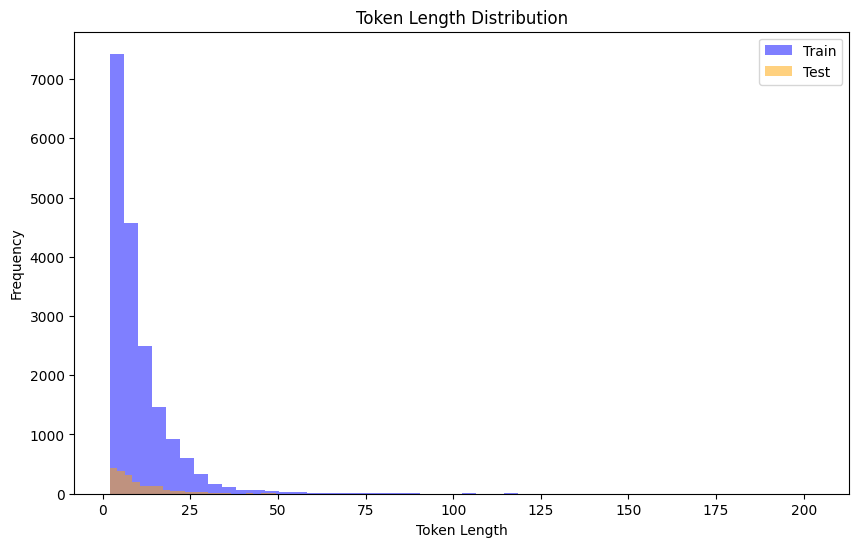

In [26]:
import matplotlib.pyplot as plt

# Calculate token lengths for train and test datasets
train_token_lengths = [len(t.split()) for t in X_train]
test_token_lengths = [len(t.split()) for t in X_test]

# Plot token length distribution
plt.figure(figsize=(10, 6))
plt.hist(train_token_lengths, bins=50, alpha=0.5, color='blue', label='Train')
plt.hist(test_token_lengths, bins=50, alpha=0.5, color='orange', label='Test')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Token Length Distribution')
plt.legend()
plt.show()

In [27]:
model = t.get_classifier()

In [28]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=8)

In [29]:
# Adding early stopping callback from TensorFlow
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='accuracy', patience=5, mode='auto')

In [30]:
history = learner.fit_onecycle(2e-5, 10,callbacks=[early_stopping])



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/10
2303/2303 [==============================] - 1330s 566ms/step - loss: 1.2241 - accuracy: 0.5246 - val_loss: 0.8822 - val_accuracy: 0.6693
Epoch 2/10
2303/2303 [==============================] - 1299s 564ms/step - loss: 0.8321 - accuracy: 0.6870 - val_loss: 0.7808 - val_accuracy: 0.7098
Epoch 3/10
2303/2303 [==============================] - 1299s 564ms/step - loss: 0.6809 - accuracy: 0.7403 - val_loss: 0.8189 - val_accuracy: 0.6922
Epoch 4/10
2303/2303 [==============================] - 1300s 564ms/step - loss: 0.5419 - accuracy: 0.7931 - val_loss: 0.8000 - val_accuracy: 0.6883
Epoch 5/10
2303/2303 [==============================] - 1298s 564ms/step - loss: 0.4287 - accuracy: 0.8376 - val_loss: 0.9633 - val_accuracy: 0.6795
Epoch 6/10
2303/2303 [==============================] - 1299s 564ms/step - loss: 0.3184 - accuracy: 0.8816 - val_loss: 0.9886 - val_accuracy: 0.7054
Epoch 7/10
2303/2303 [=====================

In [31]:
# Save the trained model
learner.save_model('/kaggle/output/bemoc.zip')

In [32]:
classes=t.get_classes()

In [33]:
cm = learner.validate(class_names=t.get_classes())

64/64 [==============================] - 14s 180ms/step
              precision    recall  f1-score   support

       Anger       0.73      0.72      0.73       362
        Fear       0.41      0.45      0.43        20
         Joy       0.72      0.68      0.70       743
        Love       0.57      0.65      0.61       414
     Sadness       0.79      0.78      0.79       429
    Surprise       0.50      0.44      0.47        79

    accuracy                           0.69      2047
   macro avg       0.62      0.62      0.62      2047
weighted avg       0.70      0.69      0.69      2047



In [34]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [35]:
!zip -r mental.zip /kaggle/output/mental-health-rand

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


	zip warning: name not matched: /kaggle/output/mental-health-rand

zip error: Nothing to do! (try: zip -r mental.zip . -i /kaggle/output/mental-health-rand)


In [36]:
!ls

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


__notebook__.ipynb


In [37]:
# from IPython.display import FileLink
# FileLink(r'/kaggle/working/mental-health-rand.zip')

In [38]:
# df_cm = pd.DataFrame(cm, index=["Anxiety","Bipolar","Borderline Personality", "Depression ", "Schizophernia","Suidal Thought","neutral",
#                                 "Alcoholism","Addiction","Aspergers","SelfHarm "],
#                      columns=["Anxiety","Bipolar","Borderline Personality", "Depression ", "Schizophernia","Suidal Thought","neutral",
#                                 "Alcoholism","Addiction","Aspergers","SelfHarm "])
# plt.figure(figsize = (10,7))
# sns.heatmap(df_cm,annot=True, fmt ="d")